In [1]:
import numpy as np
import scipy

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Практическое задание 5
## Вариант 7

## Задание 1 

Дан набор точек **S**:

| *x<sub>i</sub>* | *a<sub>1</sub>* | *a<sub>2</sub>* | *a<sub>3</sub>* | Class |
| ---- | ---- | ---- | ---- | ---- |
|*x<sub>0</sub>*|F|D|7.8|Y|
|*x<sub>1</sub>*|N|D|4.9|N|
|*x<sub>2</sub>*|N|V|5.4|N|
|*x<sub>3</sub>*|N|D|1.6|N|
|*x<sub>4</sub>*|N|D|6|N|
|*x<sub>5</sub>*|F|D|5.6|Y|
|*x<sub>6</sub>*|N|D|8.4|Y|
|*x<sub>7</sub>*|F|R|9.7|Y|
|*x<sub>8</sub>*|N|V|5.9|Y|
|*x<sub>9</sub>*|F|D|4.2|N|

1.1 *Самостоятельно* реализуйте алгоритм **NaiveBayes** (*наивный классификатор Байеса*) для **числовых** и **категориальных** признаков.

Необходимо реализовать функцию обучения классификатора на исходных данных, результат которой позволит в дальнейшем производить классификацию точек.

Заметьте, что в исходных данных атрибуты *a<sub>1</sub>* и *a<sub>2</sub>* являются категориальными признаками, а *a<sub>3</sub>* - числовым (непрерывным) признаком.

Также реализуйте функцию определения класса точки и вероятностей ее принадлежности к классам. На вход функции подается результат обучения NaiveBayes и точка в пространстве исходных данных.

Воспользовавшись реализованными функциями, обучите классификатор и определите классы и вероятности точек:

**(F,R,9.3),
(F,R,1),
(N,D,6.2)**.

### Данные

In [2]:
# Набор данных, на которых тренируем наш классификатор
D_1 = [[['F', 'D', 7.8], 'Y'],
       [['N', 'D', 4.9], 'N'],
       [['N', 'V', 5.4], 'N'],
       [['N', 'D', 1.6], 'N'],
       [['N', 'D', 6. ], 'N'],
       [['F', 'D', 5.6], 'Y'],
       [['N', 'D', 8.4], 'Y'],
       [['F', 'R', 9.7], 'Y'],
       [['N', 'V', 5.9], 'Y'],
       [['F', 'D', 4.2], 'N']]

# Точки, которые будем расспределять на классы
x_new = [['F', 'R', 9.3],
         ['F', 'R', 1.],
         ['N', 'D', 6.2]]

### Пункт 1.1

In [3]:
# Функция для работы алгоритма NaiveBayes
# D - набор точек, на которых обучаем классификатор
# return:
# dict{str: float} - априорные вероятности для классов
# dict{str: float} - значения среднего для числового параметра
# dict{str: float} - значения дисперсии для числового параметра
# dict{str: [dict{str: float}]} - значения для функции(вероятностей) категориальных признаков для каждого класса
def NaiveBayes(D):
    # Множество всех классов
    class_s = set([d_row[1] for d_row in D])
    # Инициализация априорных вероятностей классов
    P_class = {}
    # Инициализация средних
    sred = {}
    # Инициализация дисперсий
    var = {}
    # Инициализация значений функций(вероятностей) категориальных признаков для каждого класса
    f_kategory = {}
    # Инициализация для множества различных категориальных признаков
    a_set = []
    # Получение уникальных значений для каждого признака
    for i in range(2):
        a_set.append(set([d_row[0][i] for d_row in D]))
    # Размер тренирующейся модели
    n = len(D)
    
    # Проходимся по каждому классу
    for c in class_s:
        # точки принадлежащие этому классу
        d_c = [d_row[0] for d_row in D if d_row[1] == c]
        # Количество точек в этом классе
        n_i = len(d_c)
        # Рассчет априорной вероятности
        P_class[c] = n_i / n
        
        # Рассчет среднего
        sred[c] = (sum([d_row[2] for d_row in d_c]) / n_i)
        # Центрирование данных
        Z = np.array([d_row[2] - sred[c] for d_row in d_c])
        
        # Рассчет дисперсии
        var[c] = np.dot(Z.T, Z) / n_i
        
        # Инициализация переменной для значений функций(вероятностей) категориальных признаков
        kat = [{}, {}]
        
        # Проход по двум категорильным признакам
        for i in range(2):
            # Список элементов в i категориальном признаке
            elems = [d_row[i] for d_row in d_c]
            # Рассчет для каждого элемента функции(вероятности)
            for elem in a_set[i]:
                kat[i][elem] = (elems.count(elem) + 1) / (n_i + len(a_set[i]))
        
        f_kategory[c] = kat
        
    return P_class, sred, var, f_kategory

# Функция для проверки к какому классу она принадлежит
# x - точка, для которой определяют класс
# P_class - приорные вероятности для классов
# sred - начения среднего для числового параметра
# var - значения дисперсии для числового параметра
# f_kategory - начения для функции(вероятностей) категориальных признаков для каждого класса
# return:
# str - конкретный класс
# float - вероятность попадания в этот класс
def test(x, P_class, sred, var, f_kategory):
    # Инициализация максимума и полной вероятности
    maxim = -1
    sum_c = 0
    
    # Поиск максимума по всем классам
    for c, apriory_prob in P_class.items():
        # Числовой признак
        res = apriory_prob * stats.norm.pdf(x[2], sred[c], var[c]**(1 / 2))
        # Категориальные признаки
        for i in range(2):
            res *= f_kategory[c][i][x[i]]
        # Обновление максимума
        if maxim == -1 or maxim < res:
            maxim = res
            max_c = c
        sum_c += res
    # Рассчет вероятности   
    prob = maxim / sum_c
    return max_c, prob

In [4]:
# Вызов алгоритма наивного базиса
P_class, sred, var, f_kategory = NaiveBayes(D_1)
for c, p in P_class.items():
    print("Априорная вероятность", c, "равна", p)
for c, elem in sred.items():
    print("Среднее для числового признака из класса", c, "равна", elem)
    
for c, elem in var.items():
    print("Дисперсия для числового признака из класса", c, "равна", elem)
        
for i, j in f_kategory.items():
    print("Функция категориальных признаков:", i)
    for index, elem in enumerate(j):
        print(index + 1, "признак", elem)
    
print()

# Проверка на принадлежность точек к разным классам
for x in x_new:
    y, y_prob = test(x, P_class, sred, var, f_kategory)
    print("Точка", x, "принадлежит классу", y, "с вероятностью", y_prob)


Априорная вероятность Y равна 0.5
Априорная вероятность N равна 0.5
Среднее для числового признака из класса Y равна 7.4799999999999995
Среднее для числового признака из класса N равна 4.42
Дисперсия для числового признака из класса Y равна 2.3815999999999997
Дисперсия для числового признака из класса N равна 2.3376
Функция категориальных признаков: Y
1 признак {'N': 0.42857142857142855, 'F': 0.5714285714285714}
2 признак {'R': 0.25, 'D': 0.5, 'V': 0.25}
Функция категориальных признаков: N
1 признак {'N': 0.7142857142857143, 'F': 0.2857142857142857}
2 признак {'R': 0.125, 'D': 0.625, 'V': 0.25}

Точка ['F', 'R', 9.3] принадлежит классу Y с вероятностью 0.9969064172596196
Точка ['F', 'R', 1.0] принадлежит классу N с вероятностью 0.9928737542636696
Точка ['N', 'D', 6.2] принадлежит классу N с вероятностью 0.6009823396735623


## Задание 2

Дан набор точек **D**:

| *i* | *x<sub>i</sub>* | Class |
| ---- | ---- | ---- |
|0|(11.2, 5.8)|-1|
|1|(10.9, 5.3)|-1|
|2|(10.7, 5.8)|-1|
|3|(4.8 , 1  )|1 |
|4|(3.5 , 3.7)|1 |
|5|(0.8 , 6.1)|1 |
|6|(5.6 , 1.6)|1 |
|7|(11.1, 6.3)|-1|
|8|(10.3, 6.1)|-1|
|9|(4.2 , 1.4)|1 |

2.1 Реализуйте алгоритм **LinearDiscriminant** (*линейный дискриминантный анализ*) для двух классов по шагам:

- рассчитайте μ<sub>+1</sub> и μ<sub>-1</sub> и также матрицу B - матрица межклассового разброса

- рассчитайте S<sub>+1</sub> и S<sub>-1</sub> и также матрицу S - матрица внутриклассового разброса

- найдите направление **w**, которое лучше всего дискриминирует классы

- на направлении **w** найдите точку, которая лучше всего делит классы

2.2 Определите класс точки **(6.1, 12.2)**

2.3 Постройте диаграмму рассеяния исходных данных. Подпишите точки. Выделите цветом принадлежность точки к одному из классов.  

Также выведите на диаграмме:

- точки центов классов, выделите их иным маркером и подпишите
- вектор **w**
- линию **k** в направлении **w**
- спроектированные на **k** центры классов
- доп. точку из пункта 2.2, цветом укажите принадлежность к классу
- линии проекций на **k** всех точек (исходных точек, центров, доп. точки)
- найденную в пункте 2.1 точку, которая лучше всего делит классы на **k**

**☞** Размер диаграммы не меньше чем (8, 6), dpi=80. Установить одинаковый масштаб осей графика. Легенду вынести за границы графика.

### Данные

In [5]:
# Набор данных, состоящих из точек и принадлежности их к классу
D_2 = [[np.array([11.2, 5.8]), -1],
       [np.array([10.9, 5.3]), -1],
       [np.array([10.7, 5.8]), -1],
       [np.array([4.8 , 1. ]), 1 ],
       [np.array([3.5 , 3.7]), 1 ],
       [np.array([0.8 , 6.1]), 1 ],
       [np.array([5.6 , 1.6]), 1 ],
       [np.array([11.1, 6.3]), -1],
       [np.array([10.3, 6.1]), -1],
       [np.array([4.2 , 1.4]), 1 ]]
# Классы из задания
class_s = [-1, 1]

# Точка, для которой нужно будет определить класс
x_n = np.array([6.1, 12.2])

### Пункт 2.1

In [11]:
# Точки разбитые на классы
D_2_points = np.array([[point[0] for point in D_2 if point[1] == c] for c in class_s])

# Инициализация средних
mean = np.array([np.zeros(2), np.zeros(2)])

# Рассчет средних для каждого класса
for i in range(2):
    mean[i] = np.mean(D_2_points[i], axis=0)

for i in range(2):
    print("Среднее для класса '", class_s[i], "' равно ", mean[i], sep="")

# Разница средних
temp = mean[0] - mean[1]

# Рассчет матрицы межклассового разброса:
B = np.dot(np.matrix(temp).T, np.matrix(temp))

print("Матрица межклассового разброса:")
print(B)

# Центрирование данных для каждого класса
Z = []
for i in range(2):
    Z.append(D_2_points[i] - np.dot(np.matrix(np.ones(len(D_2_points[i]))).T, np.matrix(mean[i])))

print("Центрированные данные для класса '-1':", Z[0],
      "Центрированные данные для класса '1':", Z[1], sep = '\n')

# Рассчет матриц разбросов классов
S = []
for i in range(2):
    S.append(np.dot(Z[i].T, Z[i]))

# Рассчет матрицы внутриклассового разброса
S_all = S[0] + S[1]
print("Матрица внутриклассового разброса:")
print(S_all)

# Нахождение собственных векторов и чисел
temp_data = np.linalg.eig(np.dot(np.linalg.inv(S_all), B))

# Поиск максимального собственного числа и получение его собственного вектора
w_1 = np.array(temp_data[1].T)[np.argmax(temp_data[0])]

print("Собственные числа:\n", temp_data[0])
print("Собственные векторы:\n", temp_data[1])

print("Вектор w:")
print(w_1)

# Проекции точек на прямой
D_2_proj = np.array([[np.dot(w_1, point[0]) * w_1 for point in D_2 if point[1] == c] for c in class_s])
# Коэффициенты, при помощи которых получаются проекции точек
D_2_koef = [[np.dot(w_1, point[0]) for point in D_2 if point[1] == c] for c in class_s]

# Получение максимума расстояния и минимум
index_max = np.argmax([max(D_2_koef[0]), max(D_2_koef[1])])
index_min = 1 - index_max
# Нахождение минимума в максимумах и максимума в минимумах
index_max_min_point = np.argmin(D_2_koef[index_max])
index_min_max_point = np.argmax(D_2_koef[index_min])
# Рассчет точки, которая лучше всего делит классы
true_point = (D_2_proj[index_max][index_max_min_point] + D_2_proj[index_min][index_min_max_point]) / 2
# Рассчет его коэффициента
koef_true_point = (D_2_koef[index_max][index_max_min_point] + D_2_koef[index_min][index_min_max_point]) / 2

print("Точка, которая лучше всего делит классы")
print(true_point)

Среднее для класса '-1' равно [10.84  5.86]
Среднее для класса '1' равно [3.78 2.76]
Матрица межклассового разброса:
[[49.8436 21.886 ]
 [21.886   9.61  ]]
Центрированные данные для класса '-1':
[[ 0.36 -0.06]
 [ 0.06 -0.56]
 [-0.14 -0.06]
 [ 0.26  0.44]
 [-0.54  0.24]]
Центрированные данные для класса '1':
[[ 1.02 -1.76]
 [-0.28  0.94]
 [-2.98  3.34]
 [ 1.82 -1.16]
 [ 0.42 -1.36]]
Матрица внутриклассового разброса:
[[ 14.    -14.756]
 [-14.756  18.904]]
Собственные числа:
 [3.67180921e+01 1.77635684e-15]
Собственные векторы:
 [[ 0.77193852 -0.4020431 ]
 [ 0.63569719  0.91562074]]
Вектор w:
[0.77193852 0.63569719]
Точка, которая лучше всего делит классы
[6.60906599 5.44261566]


### Пункт 2.2

In [12]:
# Рассчет коэффициента для новой точки на прямой k
koef_x_n = np.dot(w_1, x_n)

# Проецируем точку на прямую
x_n_proj = np.dot(w_1, x_n) * w_1

# Рассчет класса, к которому относится точка
id_class_point = index_min if koef_x_n < koef_true_point else index_max

print("Точка ", x_n, " относится к классу '", class_s[id_class_point], "'", sep="")

Точка [ 6.1 12.2] относится к классу '-1'


### Пункт 2.3

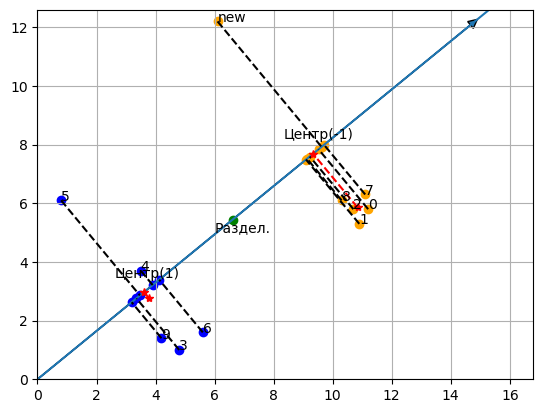

In [18]:
# Создание графика с конкретным размеров осей
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.grid(True, which='both')
ax.set_ylim(0, 6 * 2.1)
ax.set_xlim(0, 8 * 2.1)

# Построение прямой K в направлении w
plt.plot([0, w_1[0] * 20], [0, w_1[1] * 20])
# Построение стрелочки для направления w
plt.arrow(0, 0, w_1[0] * 19, w_1[1] * 19, head_width=0.3, head_length=0.3)

# Задание цветов для классов
color_s = ['orange', 'b']

# Вывод точек на диаграмму
for i in range(2):
    x_val  = [point[0] for point in D_2_points[i]]
    y_val  = [point[1] for point in D_2_points[i]]
    plt.scatter(x_val, y_val, c = color_s[i])

# Подпись точек
cnt = 0
for elem in D_2:
    plt.text(elem[0][0], elem[0][1], cnt)
    cnt = cnt + 1


# Вывод проекций точек на диаграмму    
for i in range(2):
    x_val  = [point[0] for point in D_2_proj[i]]
    y_val  = [point[1] for point in D_2_proj[i]]
    plt.scatter(x_val, y_val, c = color_s[i])

# Вывод линий для визуализации проекций на прямую
for i in range(len(D_2_points)):
    for j in range(len(D_2_points[i])):
        plt.plot([D_2_points[i][j][0], D_2_proj[i][j][0]],
                 [D_2_points[i][j][1], D_2_proj[i][j][1]],
                 linestyle = '--',
                 c = 'black')

# Проекции центров
mean_proj = [np.dot(w_1, mean[i]) * w_1 for i in range(2)]

for i in range(2):
    plt.plot([mean[i][0], mean_proj[i][0]], [mean[i][1], mean_proj[i][1]], 
             marker='*', linestyle = '--', c = 'red')
    plt.text(mean_proj[i][0] - 1, mean_proj[i][1] + 0.5, "Центр(" + str(class_s[i]) + ")")

# Вывод точки, которая лучше всего делит на классы    
plt.scatter(true_point[0], true_point[1], c='green')
# Подпись этой точки
plt.text(true_point[0] - 0.6, true_point[1] - 0.4, "Раздел.")

# Вывод точки, для которой нужно определить класс 
plt.scatter(x_n[0], x_n[1], c = color_s[id_class_point])

# Вывод проекции этой точки
plt.scatter(x_n_proj[0], x_n_proj[1], c = color_s[id_class_point])

# Подпись этой точки
plt.text(x_n[0], x_n[1], "new")

# Вывод линии проекции этой точки
plt.plot([x_n[0], x_n_proj[0]],
         [x_n[1], x_n_proj[1]],
         linestyle = '--',
         c = 'black')

## Для справки

1. Машинное обучение. Учебное пособие. Темы: 
   - Глава 12. Вероятностная классификация. Наивный байесовский классификатор. Алгоритм 12.2
   - Глава 14. Линейный дискриминантный анализ. Алгоритм 14.1